In [13]:
import sys
import os
os.environ["STATS_PBAR"] = "1"
os.environ["VRE_LOGLEVEL"] = "0"
from pathlib import Path
sys.path.append(Path.cwd().parent.__str__())
from pprint import pprint
import random
from vre.readers.multitask_dataset import MultiTaskDataset
from vre.representations import Representation, ReprOut
from vre.representations.semantic_segmentation import SemanticRepresentation
from vre.utils import MemoryData, reorder_dict
import numpy as np
import torch as tr
from media_processing_lib.collage_maker import collage_fn
from media_processing_lib.image import image_add_title, image_write
import matplotlib.pyplot as plt
from datetime import datetime

from dronescapes_representations import get_dronescapes_task_types

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
data_path = "../../data/train_set_experts/"
# data_path = "../../vre_dronescapes/norway_210821_DJI_0015_full"
stats_path = "../../data/train_set/.task_statistics.npz"
dronescapes_task_types = get_dronescapes_task_types(include_semantics_original=False, include_gt=True, include_ci=False)
reader = MultiTaskDataset(data_path, task_names=list(dronescapes_task_types),
                          task_types=dronescapes_task_types, handle_missing_data="fill_nan",
                          normalization="min_max", cache_task_stats=True, batch_size_stats=300,
                          statistics=np.load(stats_path, allow_pickle=True)["arr_0"].item())
print(reader)
print("== Shapes ==")
pprint(reader.data_shape)

[2025-01-04T11:28:25 VRE-INFO] Tasks used in this dataset: ['buildings', 'buildings(nearby)', 'camera_normals_output', 'containing', 'depth_marigold', 'depth_output', 'normals_svd(depth_marigold)', 'rgb', 'safe-landing-no-sseg', 'safe-landing-semantics', 'semantic_mask2former_r50_mapillary_converted', 'semantic_mask2former_swin_coco_converted', 'semantic_mask2former_swin_mapillary_converted', 'semantic_output', 'sky-and-water', 'transportation', 'vegetation'] (multitask_dataset.py:__init__:86)
[2025-01-04T11:28:25 VRE-INFO] External statistics provided: {'rgb': (3,), 'depth_marigold': (1,), 'normals_svd(depth_marigold)': (3,), 'semantic_output': (8,), 'camera_normals_output': (3,), 'depth_output': (1,)} (statistics.py:load_external_statistics:27)


[MultiTaskDataset]
 - Path: '/scratch/sdc/datasets/dronescapes-2024/scripts/dronescapes_viewer/../../data/train_set_experts'
 - Tasks (17): [BinaryMapper(buildings ['buildings']), BuildingsFromM2FDepth(buildings(nearby) ['buildings(nearby)']), NormalsRepresentation(camera_normals_output ['camera_normals_output']), BinaryMapper(containing ['containing']), DepthRepresentation(depth_marigold ['depth_marigold']), DepthRepresentation(depth_output ['depth_output']), NormalsRepresentation(normals_svd(depth_marigold) ['normals_svd(depth_marigold)']), RGB(rgb ['rgb']), SafeLandingAreas(safe-landing-no-sseg ['safe-landing-no-sseg']), SafeLandingAreas(safe-landing-semantics ['safe-landing-semantics']), SemanticMask2FormerMapillaryConvertedPaper(semantic_mask2former_r50_mapillary_converted ['semantic_mask2former_r50_mapillary_converted']), SemanticMask2FormerCOCOConverted(semantic_mask2former_swin_coco_converted ['semantic_mask2former_swin_coco_converted']), SemanticMask2FormerMapillaryConvertedPa

== Random loaded item ==


norway_DJI_0741_540p_1243.npz
tr[540, 960, 3] u8 x∈[0, 255], μ=116.54, σ=70.24


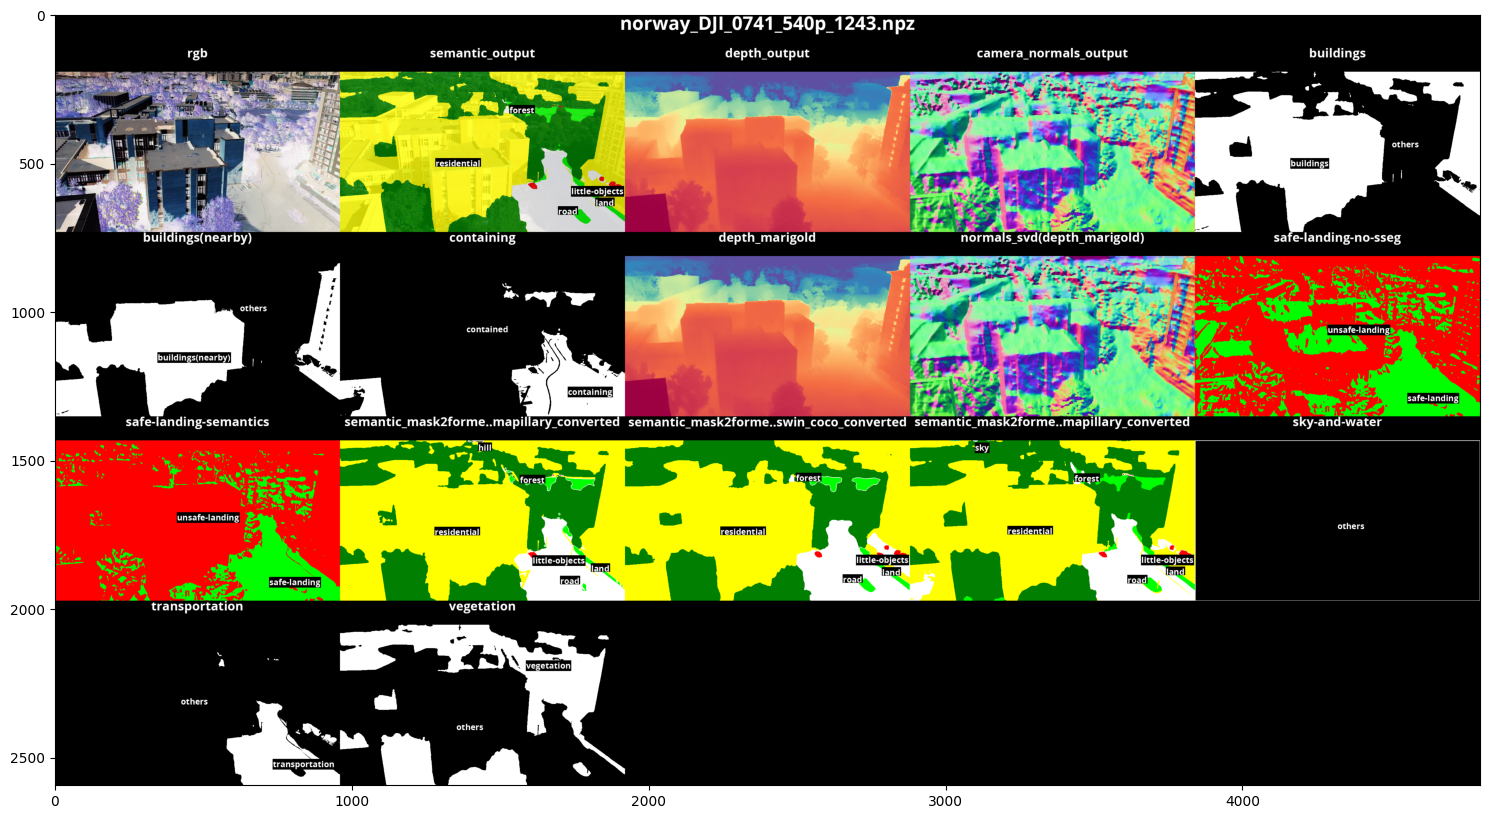

In [51]:
def plot_one(data: dict[str, tr.Tensor], title: str, name_to_task: dict[str, Representation], 
             order: list[str] | None = None) -> np.ndarray:
    def vre_plot_fn(rgb: tr.Tensor, x: tr.Tensor, node: Representation) -> np.ndarray:
        x = x.argmax(-1).type(tr.uint8) if isinstance(node, SemanticRepresentation) else x
        node.data = ReprOut(rgb.cpu().detach().numpy()[None], MemoryData(x.cpu().detach().numpy()[None]), [0])
        return node.make_images(node.data)[0]
    data["rgb"] = data["rgb"] if data["rgb"].dtype == tr.uint8 else (data["rgb"] * 255).type(tr.uint8)
    print(data["rgb"])
    img_data = {k: vre_plot_fn(data["rgb"], v, name_to_task[k]) for k, v in data.items()}
    img_data = reorder_dict(img_data, order) if order is not None else img_data
    titles = [title if len(title) < 40 else f"{title[0:19]}..{title[-19:]}" for title in img_data]
    collage = collage_fn(list(img_data.values()), titles=titles, size_px=40)
    collage = image_add_title(collage, title, size_px=55, top_padding=110)
    return collage

print("== Random loaded item ==")
rand_ix = random.randint(0, len(reader) - 1)
# rand_ix = "norway_210821_DJI_0015_full_2774.npz"
# rand_ix = "barsana_DJI_0500_0501_combined_sliced_2700_14700_805.npz"
data, name = reader[rand_ix] # get a random item
print(name)
order = ["rgb", "semantic_output", "depth_output", "camera_normals_output"]
collage = plot_one(data, title=name, order=order, name_to_task=reader.name_to_task)
plt.figure(figsize=(20, 10))
plt.imshow(collage)
image_write(collage, f"collage_{name[0:-4]}.png")

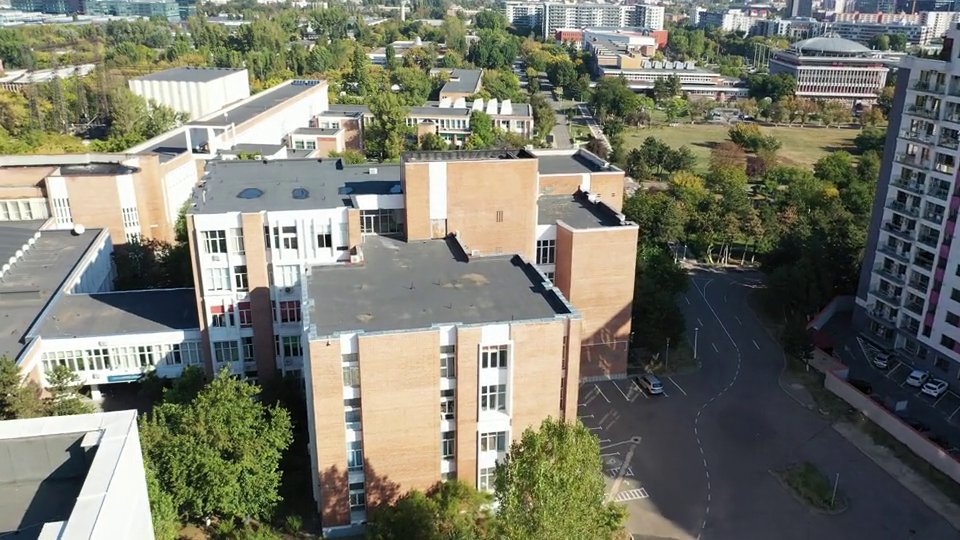

In [52]:
from PIL import Image
display(Image.fromarray(data["rgb"].numpy()))